# Overview
This notebook provides the ability to generate random droplet parameters, write them to disk, and 
train a neural network with said droplet parameters to approximate the underlying ODEs that govern 
the droplet parameters.  Once trained researchers can generate a Fortran 90 module that provides 
the ability to estimate droplet radius and temperature for some time in the future.  

The intent is that a small, reasonably trained neural network can provide accurate enough droplet 
characteristic estimations that are significantly faster than an iterative Gauss-Newton technique.
Initial testing indicates a small 4-layer network (roughly 2400 parameters) with Fortran 90 module
generated by this notebook is 30-90x faster than the existing (as of 2024/09/25) iterative approach 
which results in roughly a factor of 2x overall simulation speedup.

This notebook is broken down into the following sections:

1. ODEs of interest
2. Mapping data to/from $[-1, 1]$
3. Generating random droplets
4. Training a neural network
5. Analyzing a network's performance
6. Exporting a network to Fortran 90



In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import pandas as pd



from droplet_approximation import *
from droplet_approximation.models import *



In [2]:
model_load_paths = ["../models/network_box_residual_l1_epoch_5.pth",
                    "../models/network_box_residual_l1_epoch_14.pth"]
testing_data_file = "../data/uncoupled_eval_data_stripped.data"

commit_SHAs = ["4b63260cd37cb84034b405e0939e6ffc791a31d5",
              "4b63260cd37cb84034b405e0939e6ffc791a31d5"]


In [3]:
model_count = len(model_load_paths)

model_names = [path.split( "/" )[-1].split( "." )[0] for path in model_load_paths]

models = [ResidualNet() for i in range(model_count)]

for i in range(model_count):
    models[i].load_state_dict( torch.load(model_load_paths[i]))

In [4]:

df = pd.read_parquet("../data/test_particles.parquet")

In [5]:
df

,number observations,birth time,death time,integration times,number be failures,input radii,output radii,input temperatures,output temperatures,salt masses,air temperatures,relative humidities,air densities
particle id,,,,,,,,,,,,,
32,1767.0,2.547703,193.461212,"[0.12500286, 0.12530851, 0.12574434, 0.1263282...",1.0,"[2e-07, 2e-07, 7.040546e-07, 1.0435333e-06, 1....","[2e-07, 7.040546e-07, 1.0435333e-06, 1.3147841...","[290.0, 290.19815, 290.50897, 290.50116, 290.4...","[290.19815, 290.50897, 290.50116, 290.497, 290...","[2.2116812e-18, 2.2116812e-18, 2.2116812e-18, ...","[290.19815, 290.1961, 290.1899, 290.18515, 290...","[1.0269803, 1.0270286, 1.0270241, 1.027001, 1....","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
33,2248.0,2.547703,226.145462,"[0.12500286, 0.12530851, 0.12574434, 0.1263282...",0.0,"[2e-07, 7.690911e-07, 1.1509227e-06, 1.4551285...","[7.690911e-07, 1.1509227e-06, 1.4551285e-06, 1...","[290.0, 290.50232, 290.50827, 290.5072, 290.50...","[290.50232, 290.50827, 290.5072, 290.5049, 290...","[2.2116812e-18, 2.2116812e-18, 2.2116812e-18, ...","[290.1156, 290.12085, 290.11838, 290.11487, 29...","[1.0334499, 1.0335224, 1.0335499, 1.0335798, 1...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
34,1202.0,2.547703,137.542831,"[0.12500286, 0.12530851, 0.12574434, 0.1263282...",0.0,"[2e-07, 9.422163e-07, 1.4311536e-06, 1.8179413...","[9.422163e-07, 1.4311536e-06, 1.8179413e-06, 2...","[290.0, 292.22034, 292.19965, 292.20438, 292.2...","[292.22034, 292.19965, 292.20438, 292.20822, 2...","[2.2116812e-18, 2.2116812e-18, 2.2116812e-18, ...","[291.60318, 291.5828, 291.58682, 291.59015, 29...","[1.0515635, 1.0514138, 1.0513583, 1.0513252, 1...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
35,1103.0,2.547703,126.703217,"[0.12500286, 0.12530851, 0.12574434, 0.1263282...",0.0,"[2e-07, 8.0835e-07, 1.2150989e-06, 1.5381099e-...","[8.0835e-07, 1.2150989e-06, 1.5381099e-06, 1.8...","[290.0, 290.05463, 290.05203, 290.05255, 290.0...","[290.05463, 290.05203, 290.05255, 290.0529, 29...","[2.2116812e-18, 2.2116812e-18, 2.2116812e-18, ...","[289.61996, 289.61633, 289.61615, 289.616, 289...","[1.0379832, 1.0380492, 1.0380073, 1.0379739, 1...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
36,2662.0,2.547703,270.402130,"[0.12500286, 0.12530851, 0.12574434, 0.1263282...",0.0,"[2e-07, 5.588609e-07, 8.003663e-07, 9.947823e-...","[5.588609e-07, 8.003663e-07, 9.947823e-07, 1.1...","[290.0, 289.8356, 289.82626, 289.8246, 289.823...","[289.8356, 289.82626, 289.8246, 289.82373, 289...","[2.2116812e-18, 2.2116812e-18, 2.2116812e-18, ...","[289.6583, 289.65582, 289.65466, 289.6535, 289...","[1.0152293, 1.0152594, 1.0152467, 1.0152352, 1...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
207,897.0,2.547703,104.024315,"[0.12500286, 0.12530851, 0.12574434, 0.1263282...",1.0,"[2e-07, 2e-07, 7.604476e-07, 1.1360195e-06, 1....","[2e-07, 7.604476e-07, 1.1360195e-06, 1.4352302...","[290.0, 290.2547, 290.632, 290.63013, 290.6298...","[290.2547, 290.632, 290.63013, 290.62982, 290....","[2.2116812e-18, 2.2116812e-18, 2.2116812e-18, ...","[290.2547, 290.2563, 290.25528, 290.25433, 290...","[1.0324576, 1.0323992, 1.0323583, 1.0323207, 1...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
224,1672.0,2.547703,187.265976,"[0.12500286, 0.12530851, 0.12574434, 0.1263282...",0.0,"[2e-07, 7.099339e-07, 1.0527015e-06, 1.3263601...","[7.099339e-07, 1.0527015e-06, 1.3263601e-06, 1...","[290.0, 289.97403, 289.97098, 289.97183, 289.9...","[289.97403, 289.97098, 289.97183, 289.97293, 2...","[2.2116812e-18, 2.2116812e-18, 2.2116812e-18, ...","[289.65402, 289.65286, 289.65298, 289.65335, 2...","[1.0279802, 1.0279363, 1.02792, 1.0279104, 1.0...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
225,3314.0,2.547703,346.819397,"[0.12500286, 0.12530851, 0.12574434, 0.1263282...",0.0,"[2e-07, 8.736594e-07, 1.3201285e-06, 1.6736957...","[8.736594e-07, 1.3201285e-06, 1.6736957e-06, 1...","[290.

In [ ]:
# Calculate NRMSE for each particle
# Perhaps we could write a script to do this en masse on the cluster
nrmse = np.zeros(len(df))
for i in range(len(df)):
    particle_df = df.iloc[i]

    input_parameters = np.stack(particle_df[[
        "input radii",
        "input temperatures",
        "salt masses",
        "air temperatures",
        "relative humidities",
        "air densities"
    ]].to_numpy(), axis=-1)

    times = np.cumsum(particle_df["integration times"])

    model_output = do_iterative_inference(
                            input_parameters, 
                            times,
                            models[0],
                            "cpu"
                        )

    nrmse[i] = calculate_nrmse( model_output, input_parameters[:, :2], standard_distance  )

    # For consistency sake calculating NRMSE against BE
    # Currently leads to issues where BE because there is
    # no be flag array, the MLP is scored lower when
    # BE fails. NRMSE can be calculated against BDF instead
    # by uncommenting the following code:

    #truth_output = do_iterative_bdf(
    #                        input_parameters, 
    #                        times)
    #
    #nrmse[i] = calculate_nrmse( model_output, truth_output,  standard_distance  )



In [9]:
df["nrmse"] = nrmse

Trajectory statistics:
max:  [3.0287139e-05 2.9863507e+02 2.2116812e-18 2.9861639e+02 1.0701332e+00
 1.0000000e+00]
min:  [2.0000000e-07 2.8918643e+02 2.2116812e-18 2.8891708e+02 1.0058650e+00
 1.0000000e+00]
max:  [ 0.80455154  0.78500646 -0.05545044  0.78330857  0.7792579   0.        ]
min:  [-0.781069   -0.07396074 -0.05545044 -0.09844694  0.06516642  0.        ]
max tempearture diff:  0.68899536
network_box_residual_l1_epoch_5 NRMSE against BE: 0.15719628427177668%


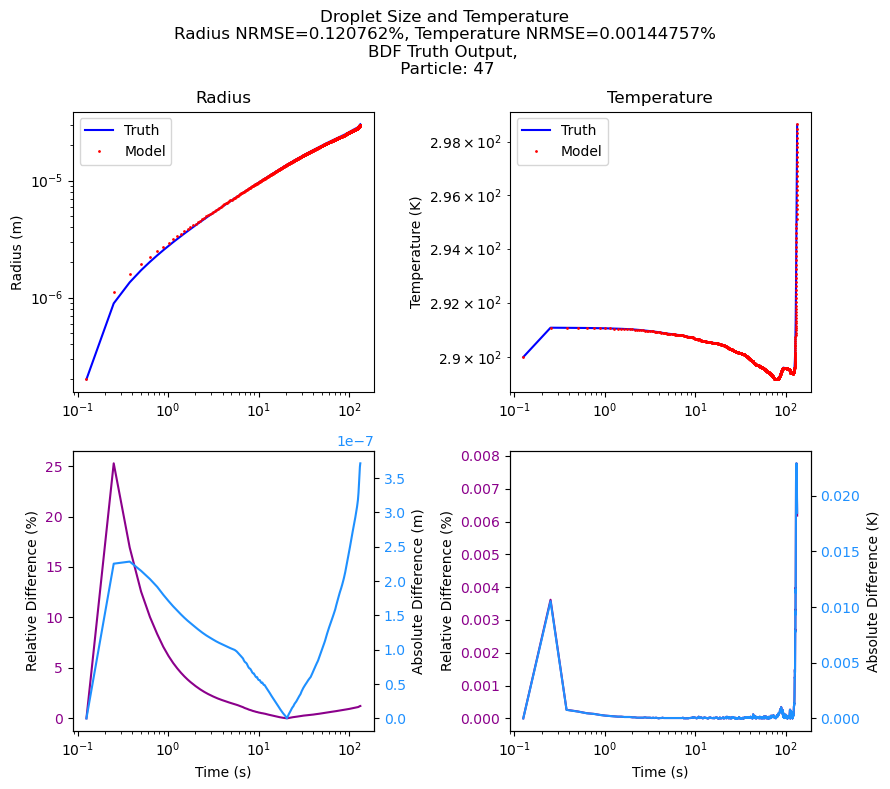

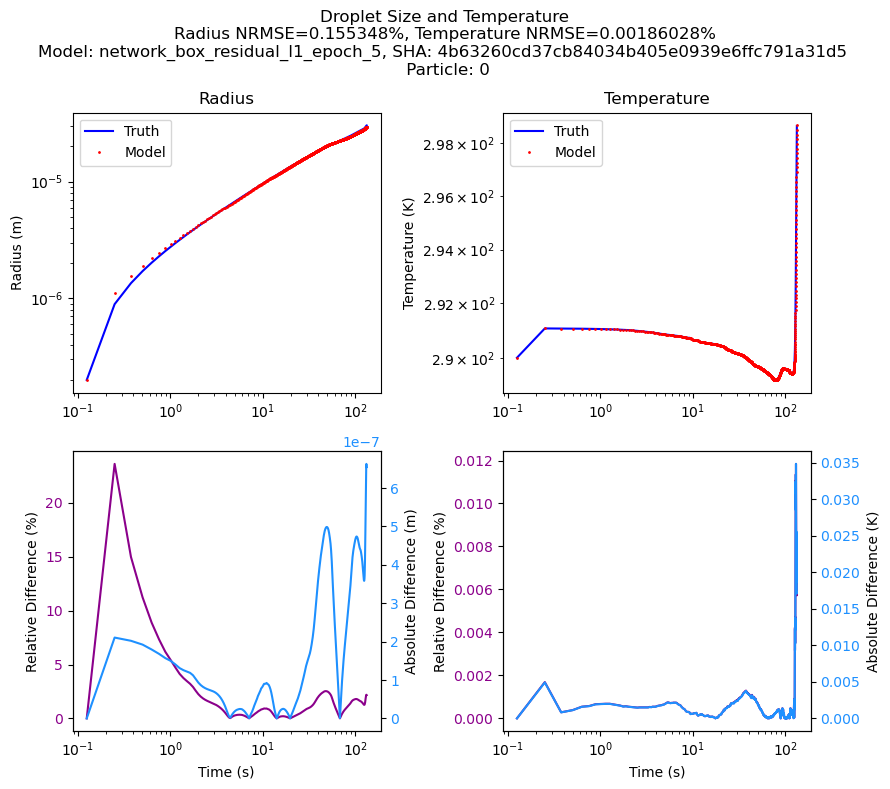

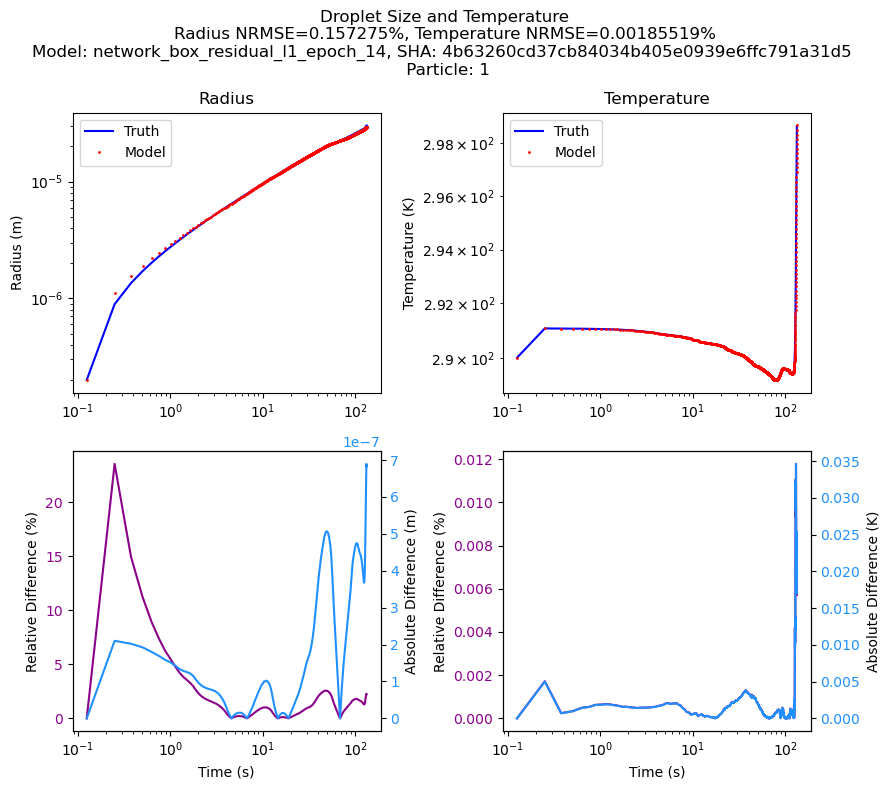

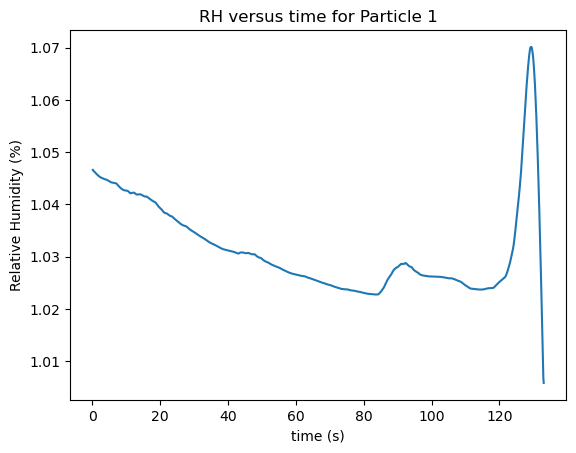

Trajectory statistics:
max:  [2.0755360e-05 2.9865683e+02 2.2116812e-18 2.9856152e+02 1.0830927e+00
 1.0000000e+00]
min:  [2.0000000e-07 2.8820279e+02 2.2116812e-18 2.8792838e+02 1.0069814e+00
 1.0000000e+00]
max:  [ 0.6851855   0.7869845  -0.05545044  0.7783203   0.9232521   0.        ]
min:  [-0.781069   -0.16338278 -0.05545044 -0.18832952  0.07757081  0.        ]
max tempearture diff:  0.89697266
network_box_residual_l1_epoch_5 NRMSE against BE: 0.16752640949562192%


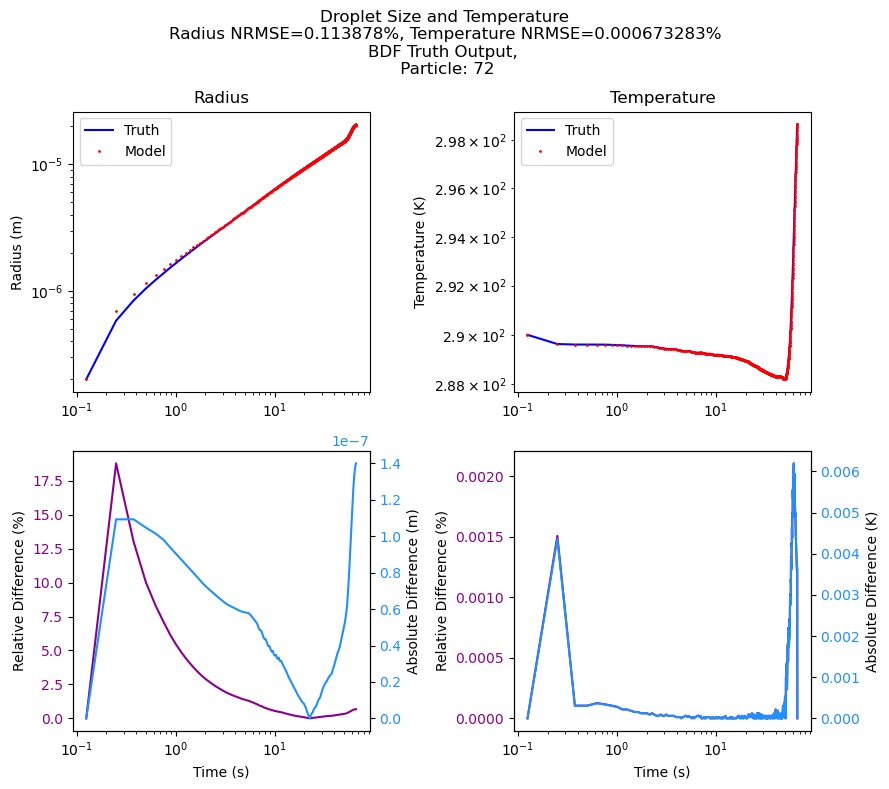

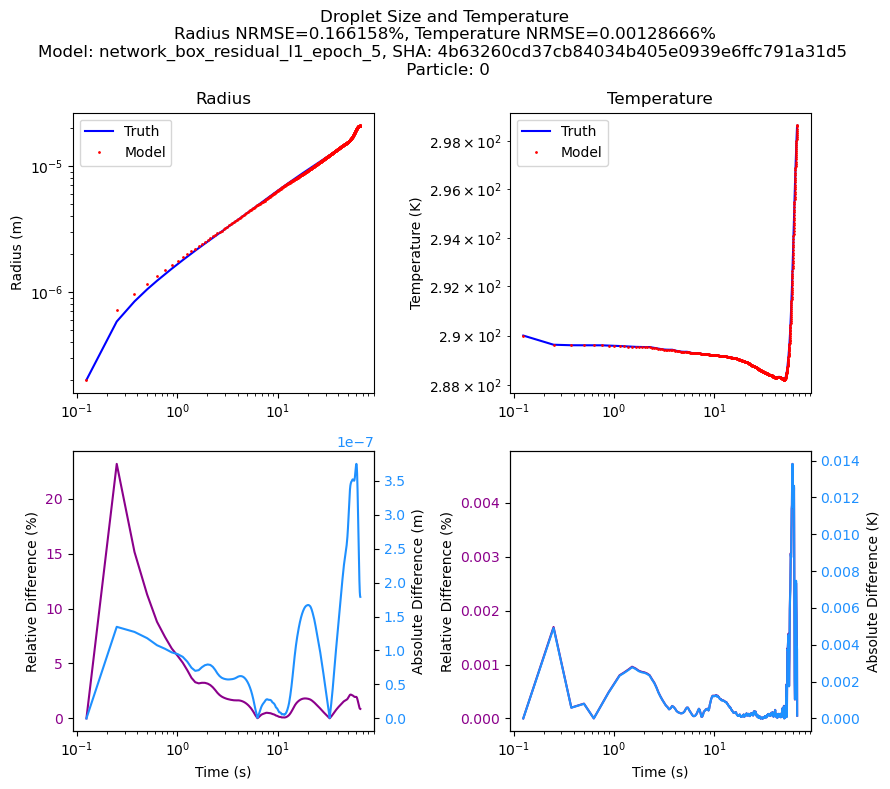

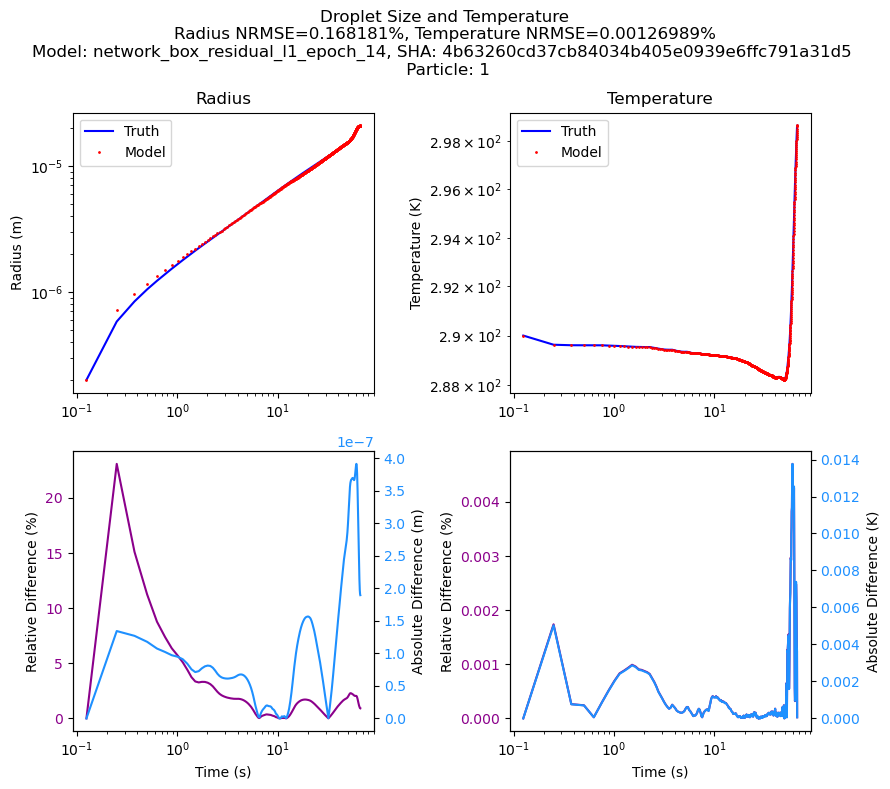

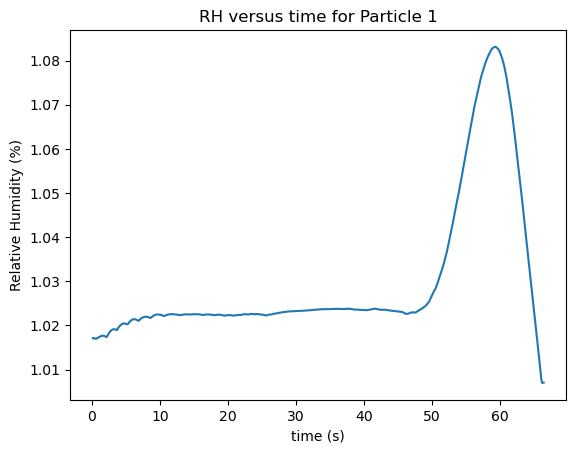

Trajectory statistics:
max:  [1.8271036e-05 2.9846494e+02 2.2116812e-18 2.9831796e+02 1.0750153e+00
 1.0000000e+00]
min:  [2.0000000e-07 2.8871686e+02 2.2116812e-18 2.8844315e+02 1.0107049e+00
 1.0000000e+00]
max:  [ 0.6449186   0.7695396  -0.05545044  0.75617844  0.8335034   0.        ]
min:  [-0.781069   -0.11664928 -0.05545044 -0.1415322   0.11894306  0.        ]
max tempearture diff:  0.83587646
network_box_residual_l1_epoch_5 NRMSE against BE: 0.17132837092503905%


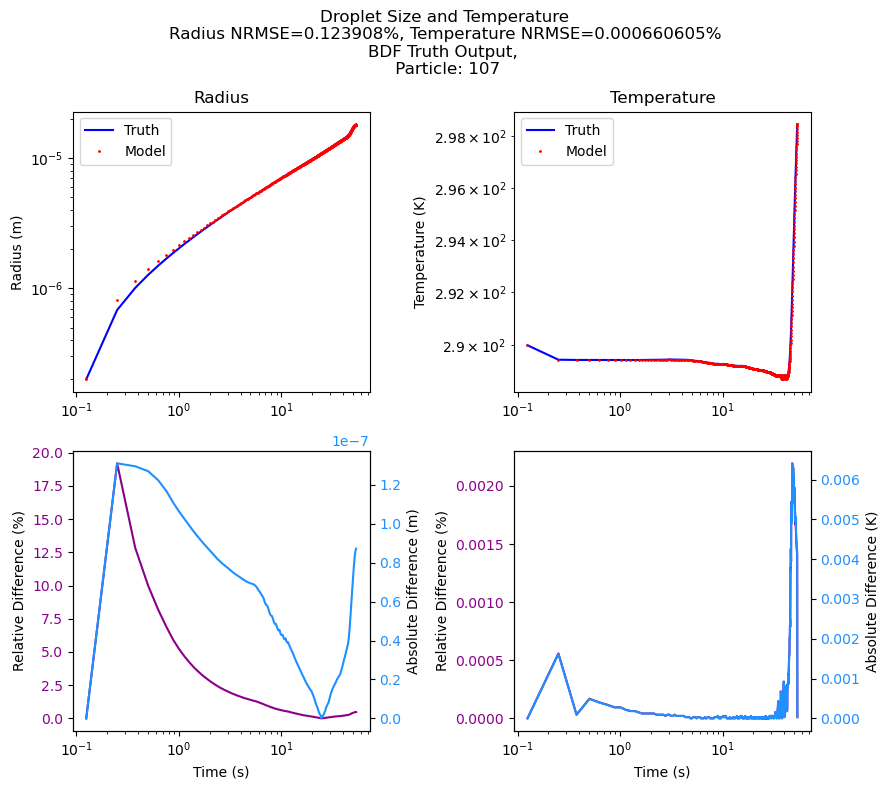

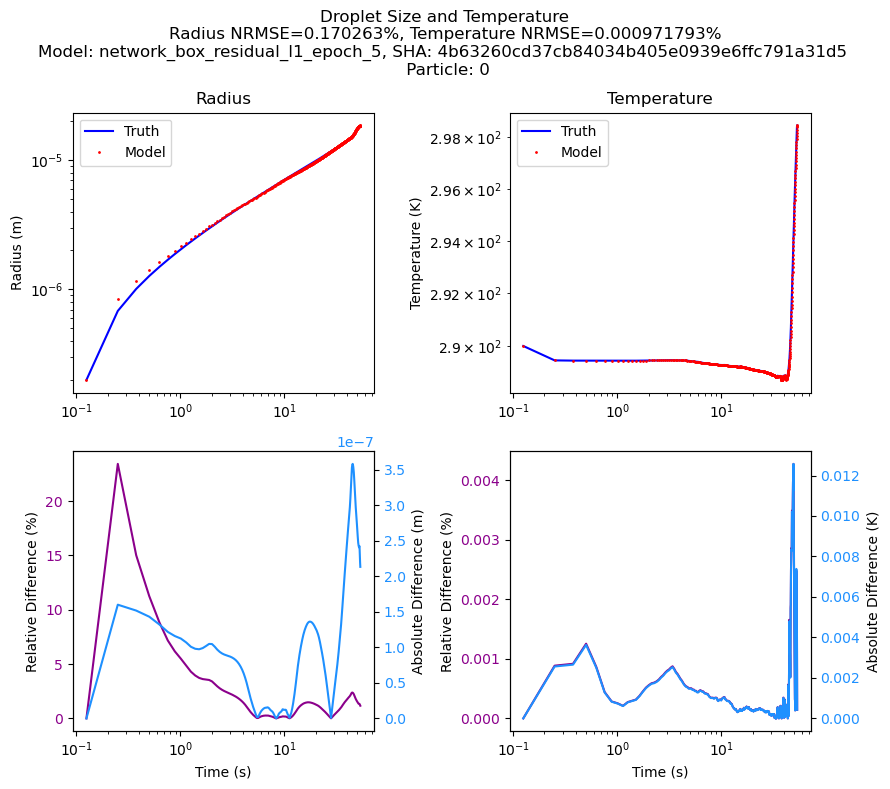

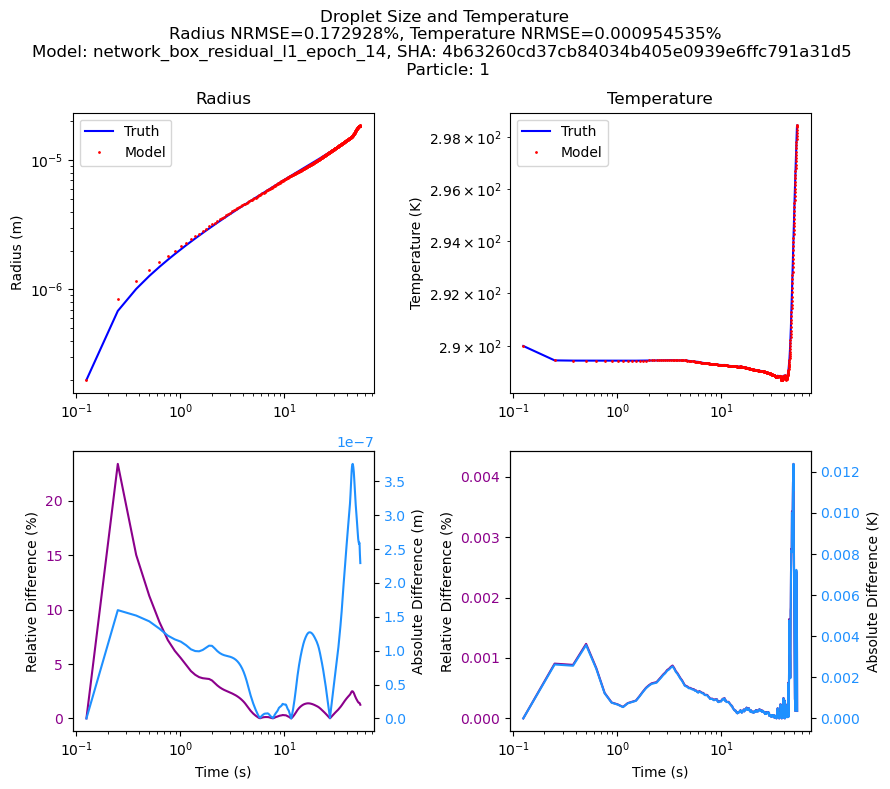

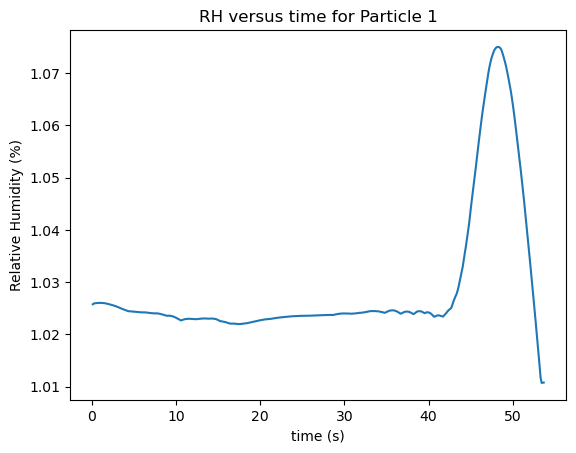

Trajectory statistics:
max:  [2.2029986e-05 2.9876849e+02 2.2116812e-18 2.9871237e+02 1.0699103e+00
 1.0000000e+00]
min:  [2.0000000e-07 2.8868774e+02 2.2116812e-18 2.8844144e+02 1.0042549e+00
 1.0000000e+00]
max:  [ 0.70401037  0.7971358  -0.05545044  0.7920338   0.77678096  0.        ]
min:  [-0.781069   -0.11929598 -0.05545044 -0.14168757  0.04727708  0.        ]
max tempearture diff:  0.7652893
network_box_residual_l1_epoch_5 NRMSE against BE: 0.14282878255471587%


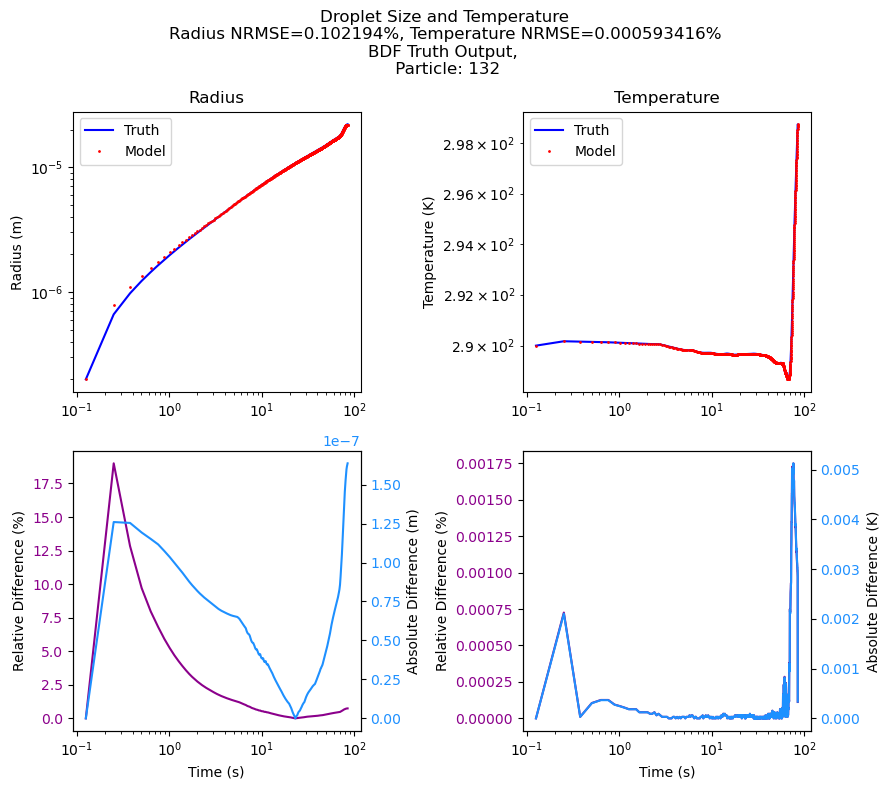

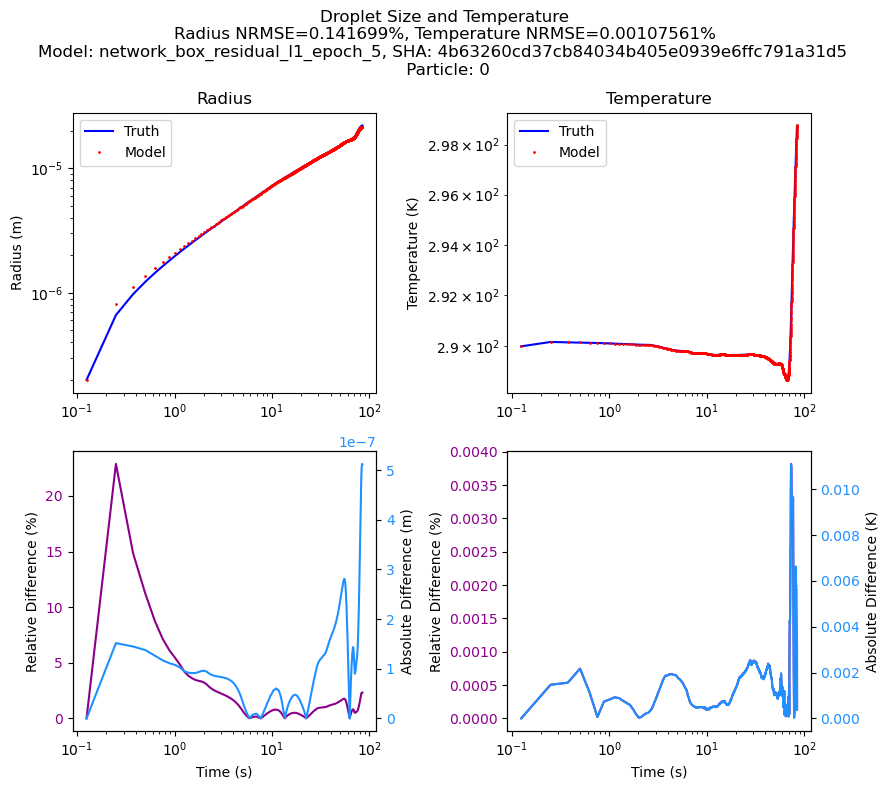

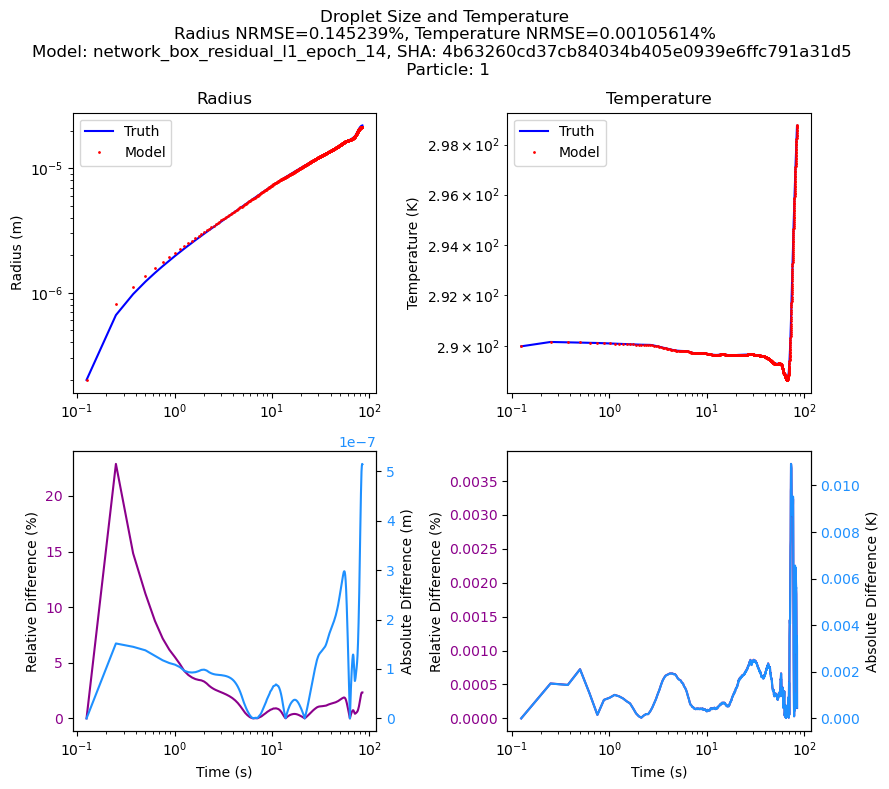

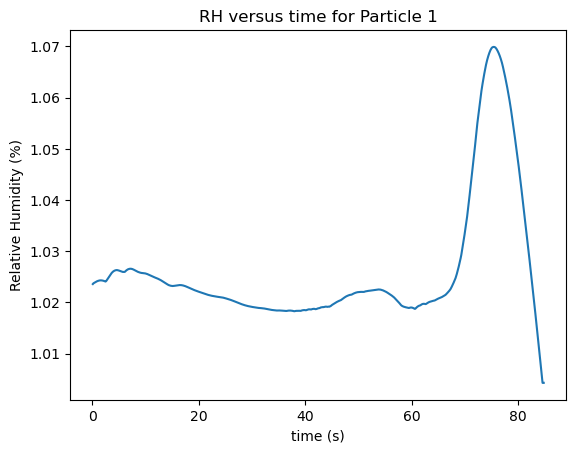

Trajectory statistics:
max:  [2.5045043e-05 2.9870834e+02 2.2116812e-18 2.9863608e+02 1.0761217e+00
 1.0000000e+00]
min:  [2.0000000e-07 2.8687973e+02 2.2116812e-18 2.8645471e+02 1.0057329e+00
 1.0000000e+00]
max:  [ 0.7445249   0.7916676  -0.05545044  0.785098    0.8457965   0.        ]
min:  [-0.781069   -0.2836609  -0.05545044 -0.3222989   0.06369882  0.        ]
max tempearture diff:  3.5116882
network_box_residual_l1_epoch_5 NRMSE against BE: 0.15529971569776535%


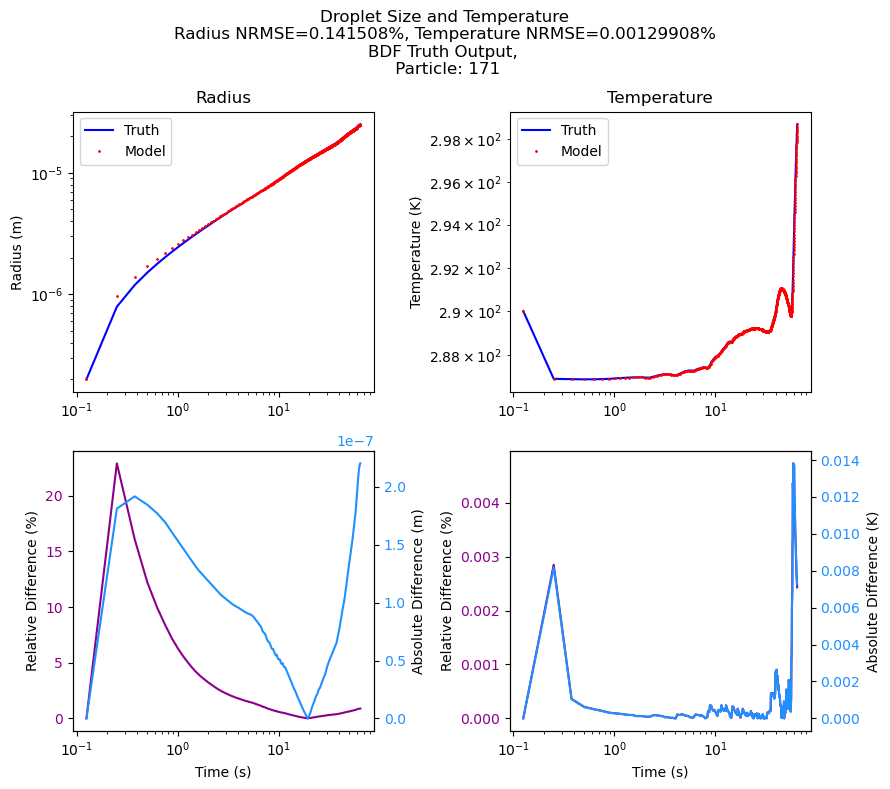

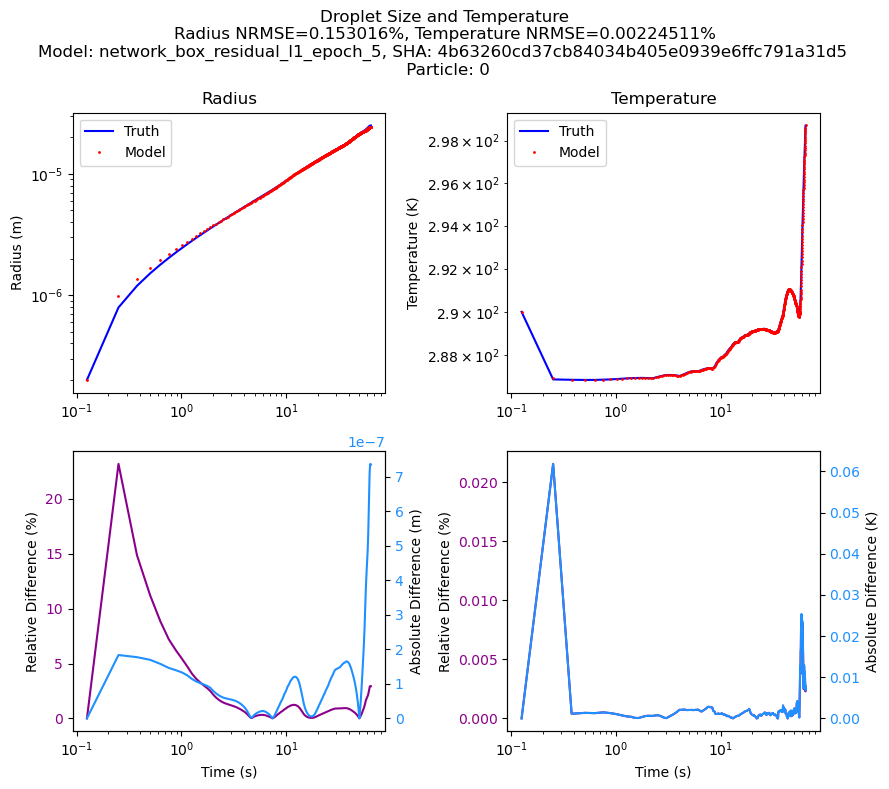

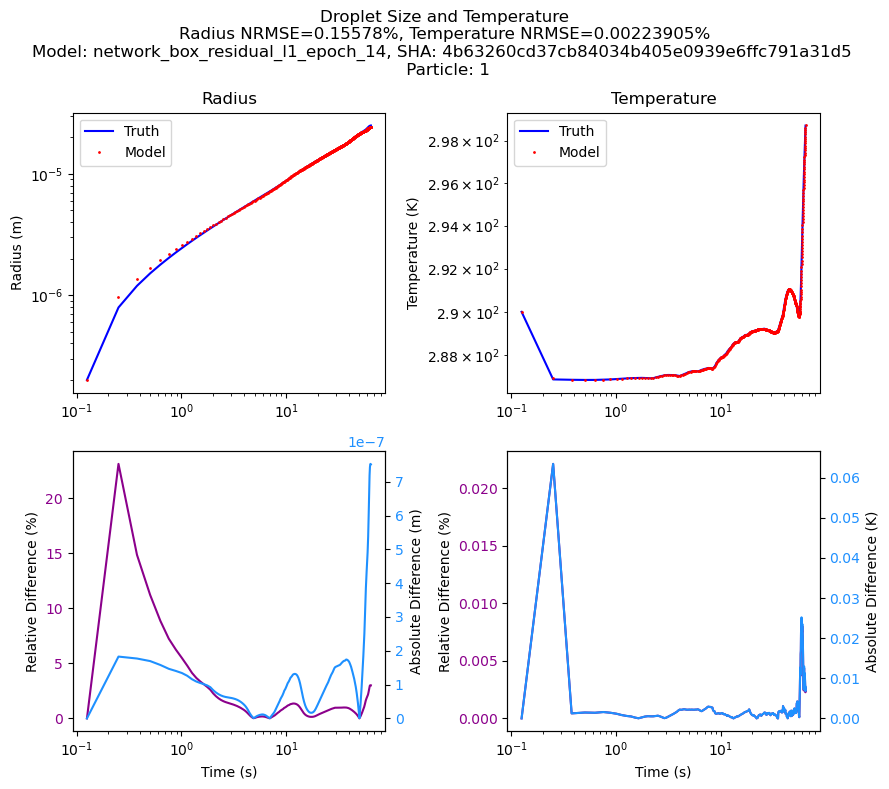

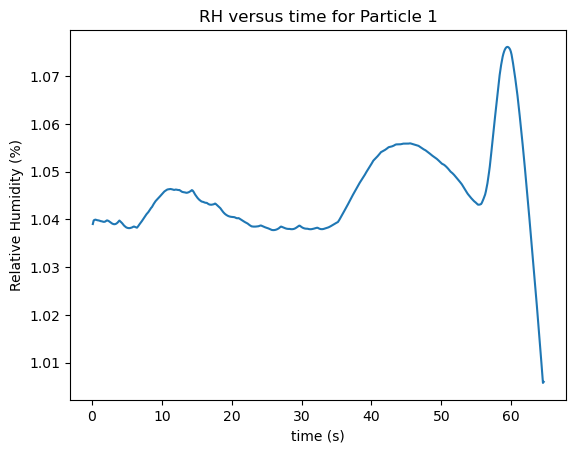

In [ ]:
#TIME_RANGE = (50.0, 150.0)
TIME_RANGE = None

for i in df[(df["nrmse"] >= df["nrmse"].quantile(.95))].index:
    particle_df = df.loc[df.index == i]
    input_parameters = np.stack(particle_df[[
        "input radii",
        "input temperatures",
        "salt masses",
        "air temperatures",
        "relative humidities",
        "air densities"
    ]].to_numpy()[0], axis=-1)

    print("Trajectory statistics:")
    print("max: ", input_parameters.max(axis=0))
    print("min: ", input_parameters.min(axis=0))
    print("max: ", normalize_droplet_parameters( input_parameters.max( axis=0 ) ) ) 
    print("min: ", normalize_droplet_parameters( input_parameters.min( axis=0) ) )
    print("max tempearture diff: ", (input_parameters[:, 1] - input_parameters[:, 3]).max())
    print("{} NRMSE against BE: {}%".format(model_names[0], particle_df["nrmse"].values[0]*100))

    times = np.cumsum(particle_df["integration times"].to_numpy()[0])
    model_outputs = [ do_iterative_inference(
                            input_parameters, 
                            times,
                            models[i],
                            "cpu"
                        ) for i in range( model_count ) ]
    truth_output = do_iterative_bdf(
        input_parameters,
        times,
        "cpu"
    )

    model_distances = [ standard_distance( input_parameters[:, :2], model_outputs[i] ) for i in range( model_count ) ]
    truth_distance = standard_distance( input_parameters[:, :2], truth_output)
    analyze_model_particle_performance(
        times,
        input_parameters[:, :2], 
        truth_output,
        truth_distance,
        "BDF Truth Output, \n Particle: " + str( i ),
        time_range=TIME_RANGE
    )
    for i in range( model_count ): 
        analyze_model_particle_performance(
            times,
            input_parameters[:, :2], 
            model_outputs[i],
            model_distances[i],
            "Model: " + model_names[i] + ", SHA: " + commit_SHAs[i] + " \n Particle: " + str( i ),
            time_range=TIME_RANGE
        )
    plt.figure()
    plt.plot(times, particle_df["relative humidities"].to_numpy()[0])
    plt.title("RH versus time for Particle " + str(i))
    plt.xlabel("time (s)")
    plt.ylabel("Relative Humidity (%)") 
    plt.show()
